In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/CV/Lab2/main.png")
img2 = cv2.imread("/content/drive/MyDrive/CV/Lab2/train.png")
img3 = cv2.imread("/content/drive/MyDrive/CV/Lab2/Intersect-1.png")
img4 = cv2.imread("/content/drive/MyDrive/CV/Lab2/Intersect.png")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
keypoints_3, descriptors_3 = sift.detectAndCompute(img3, None)
keypoints_4, descriptors_4 = sift.detectAndCompute(img4, None)

## Custom matcher

In [ ]:
def matcher_lowe(descriptors_1, descriptors_2, k=2):
  distances = np.linalg.norm(descriptors_1[:, np.newaxis] - descriptors_2[np.newaxis, :], axis=-1)
  min_dist_indexes = np.argsort(distances, axis=1)
  min_dists = np.take_along_axis(distances, min_dist_indexes, axis=1)[:, :k]

  zero_matches = []
  for i in range(len(descriptors_1)):
    new_row = []
    for j in range(k):
      new_row.append(cv2.DMatch(i, min_dist_indexes[i,j], min_dists[i,j]))
    zero_matches.append(new_row)

  matches = []
  for row in zero_matches:
    matches.append(tuple(row))

  return matches

In [ ]:
def sift_image_matcher(image1, image2, points=20):
  sift = cv2.xfeatures2d.SIFT_create()

  keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)

  matches = matcher_lowe(descriptors_1, descriptors_2)

  good = []
  for m, n in matches:
    if m.distance < 0.8 * n.distance:
      good.append(m)

  matches = sorted(good, key=lambda x: x.distance)
  matches = tuple(matches)

  custom_matches = cv2.drawMatches(image1, keypoints_1, image2, keypoints_2, matches[:points], None, flags=2)

  return custom_matches 

In [ ]:
custom_matches = sift_image_matcher(img1, img2)
custom_matches_2 = sift_image_matcher(img3, img4)

##FlannMatcher

In [ ]:
def sift_image_flann_matcher(image1, image2, points=20):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)

  FLAN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLAN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)

  flann_matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

  good_matches = []

  for m1, m2 in flann_matches:
    if m1.distance < 0.5 * m2.distance:
      good_matches.append([m1])

  flann_matches =cv2.drawMatchesKnn(image1, keypoints_1, image2, keypoints_2, good_matches[:points], None, flags=2)

  return flann_matches

In [ ]:
flann_matches = sift_image_flann_matcher(img1, img2)
flann_matches_2 = sift_image_flann_matcher(img3, img4)

##ORB and BFMatcher

In [ ]:
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
keypoints3, descriptors3 = orb.detectAndCompute(img3, None)
keypoints4, descriptors4 = orb.detectAndCompute(img4, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
bf_matches = bf.match(descriptors1, descriptors2)
bf_matches = sorted(bf_matches, key=lambda x:x.distance)

ORB_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, bf_matches[:20], None, flags=2)

bf_matches_2 = bf.match(descriptors3, descriptors4)
bf_matches_2 = sorted(bf_matches_2, key=lambda x:x.distance)

ORB_matches_2 = cv2.drawMatches(img3, keypoints3, img4, keypoints4, bf_matches_2[:20], None, flags=2)

##Comparasion

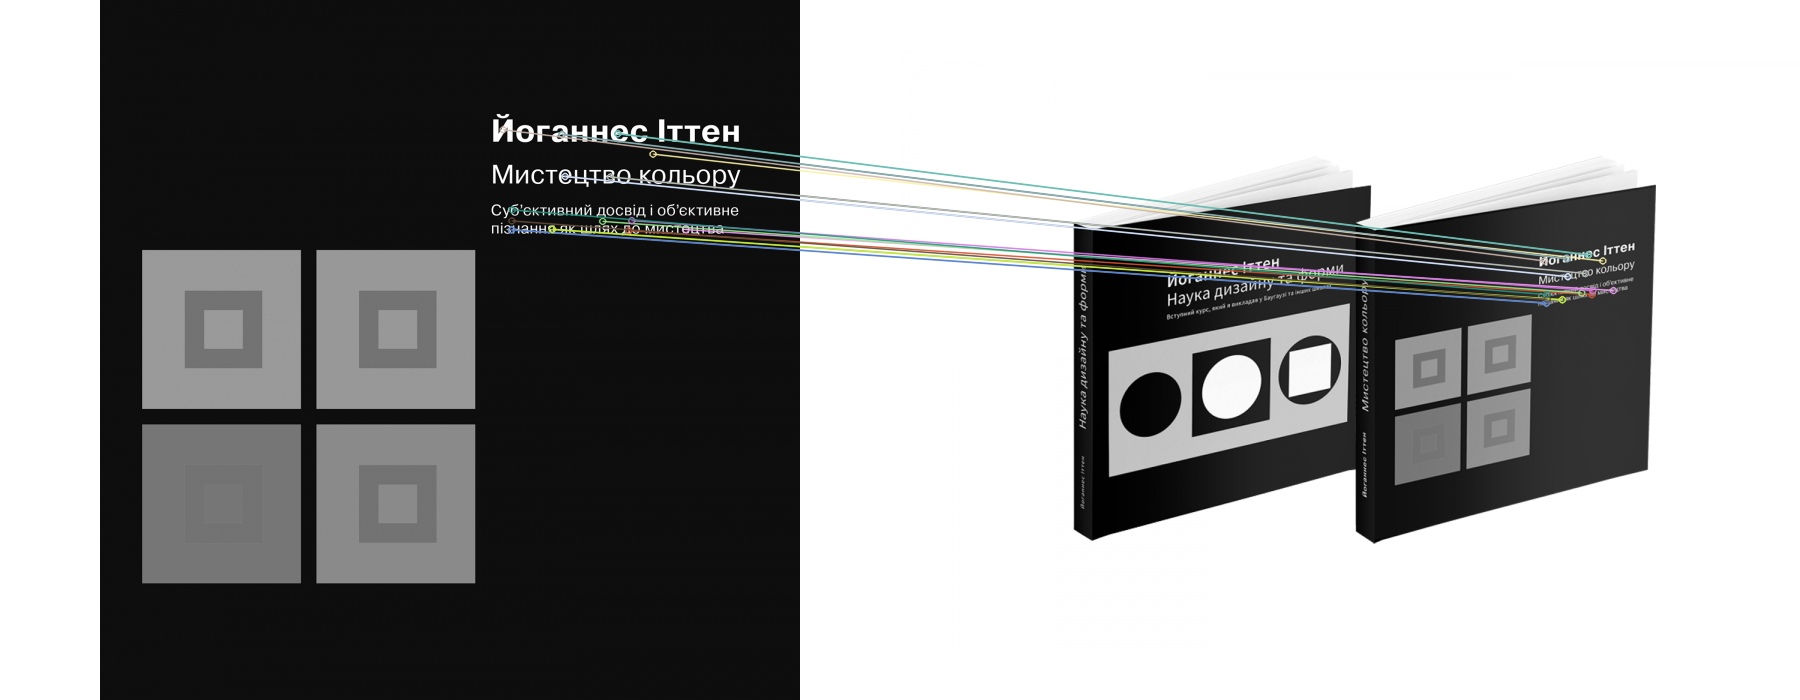

In [ ]:
cv2_imshow(custom_matches)

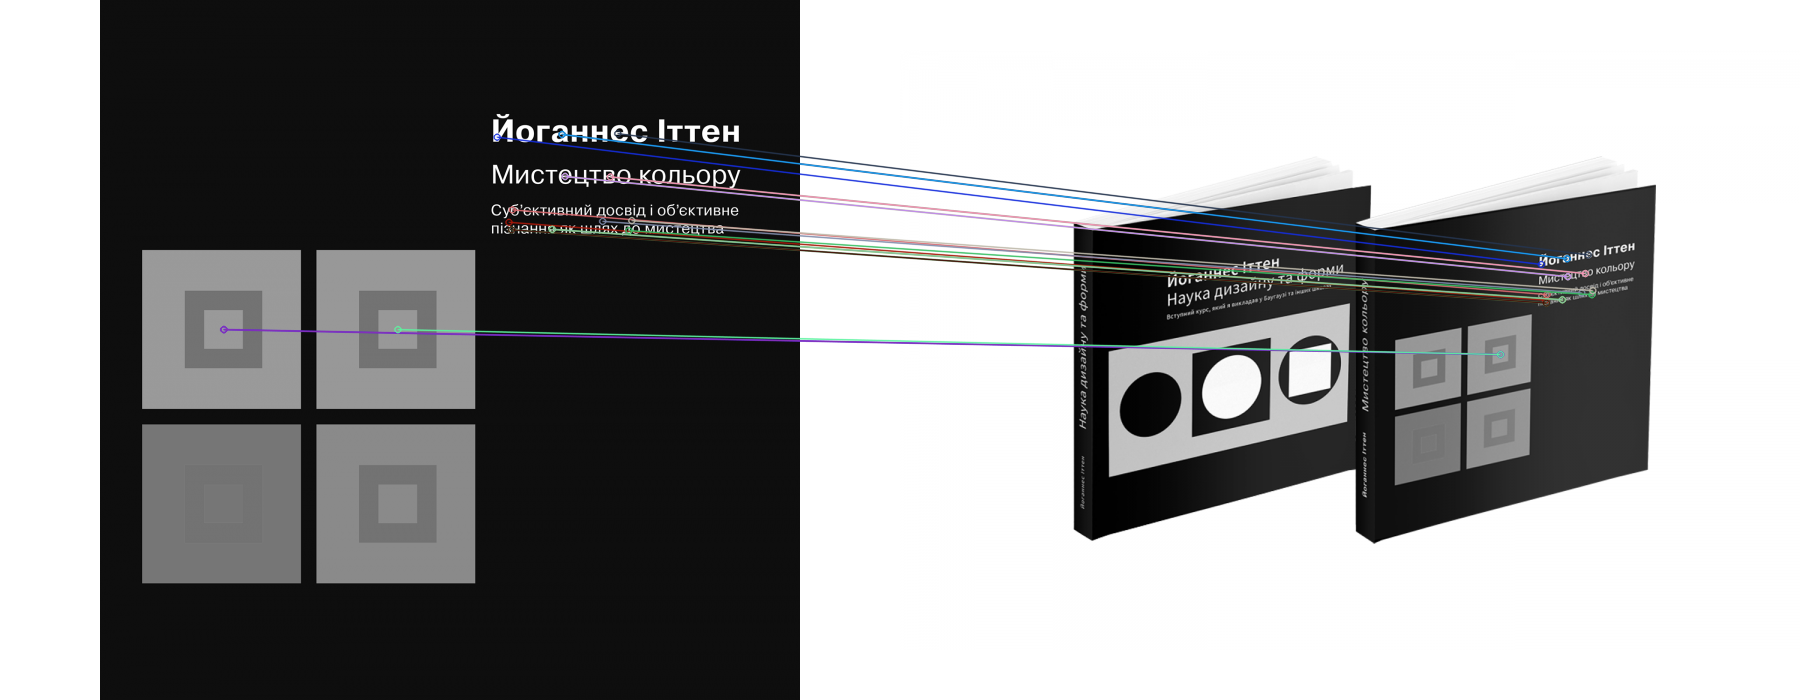

In [ ]:
cv2_imshow(flann_matches)

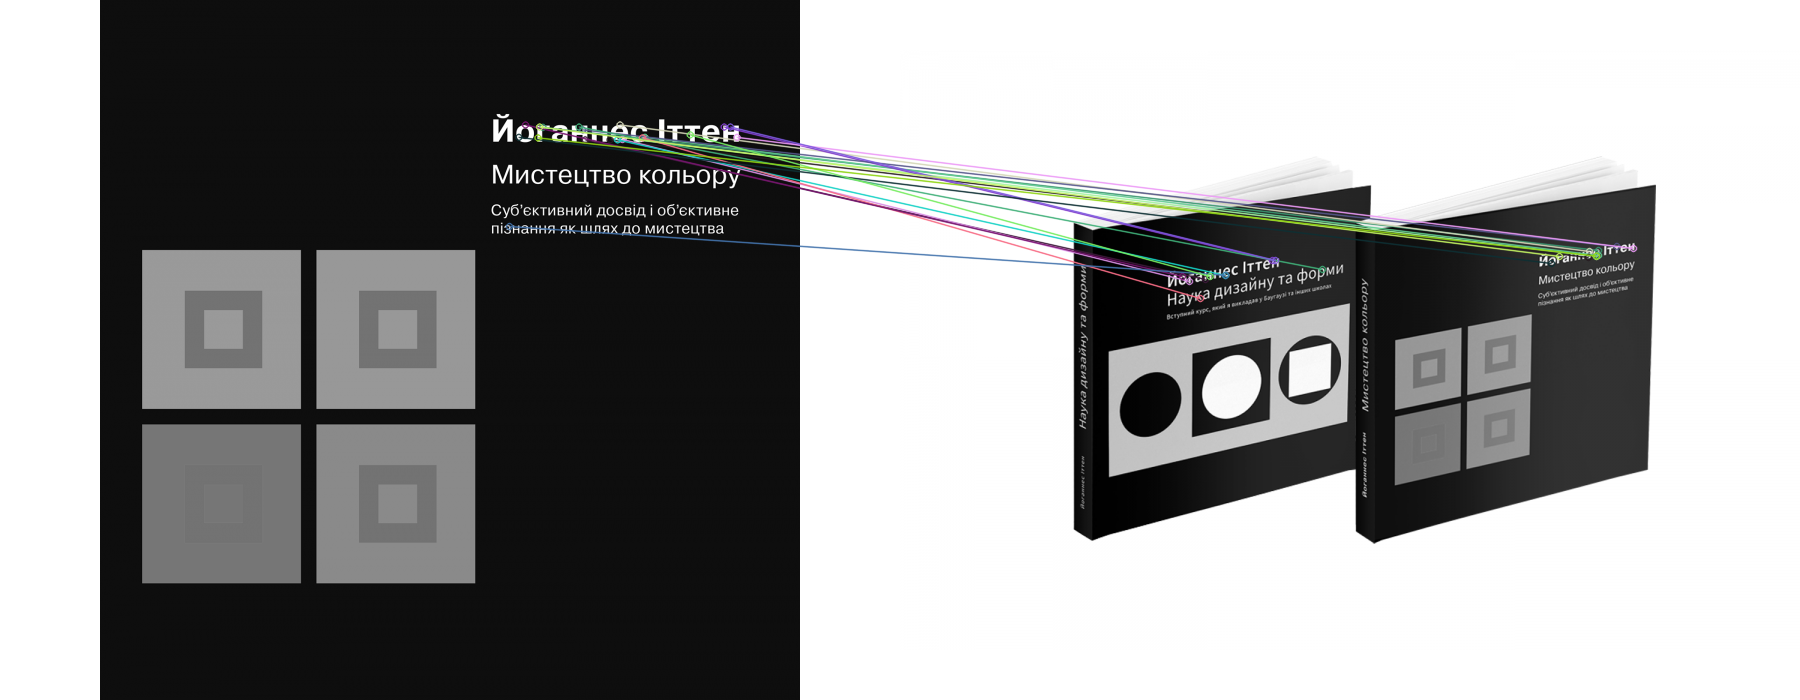

In [ ]:
cv2_imshow(ORB_matches)

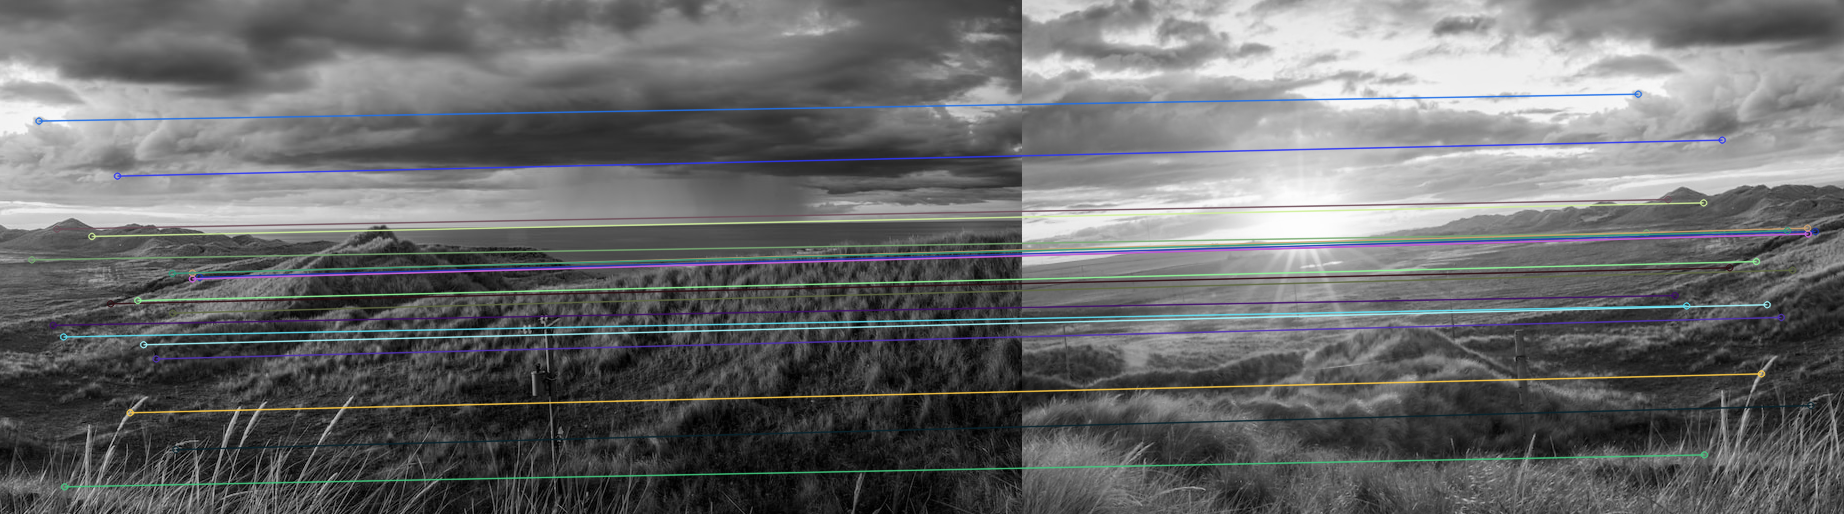

In [ ]:
cv2_imshow(custom_matches_2)

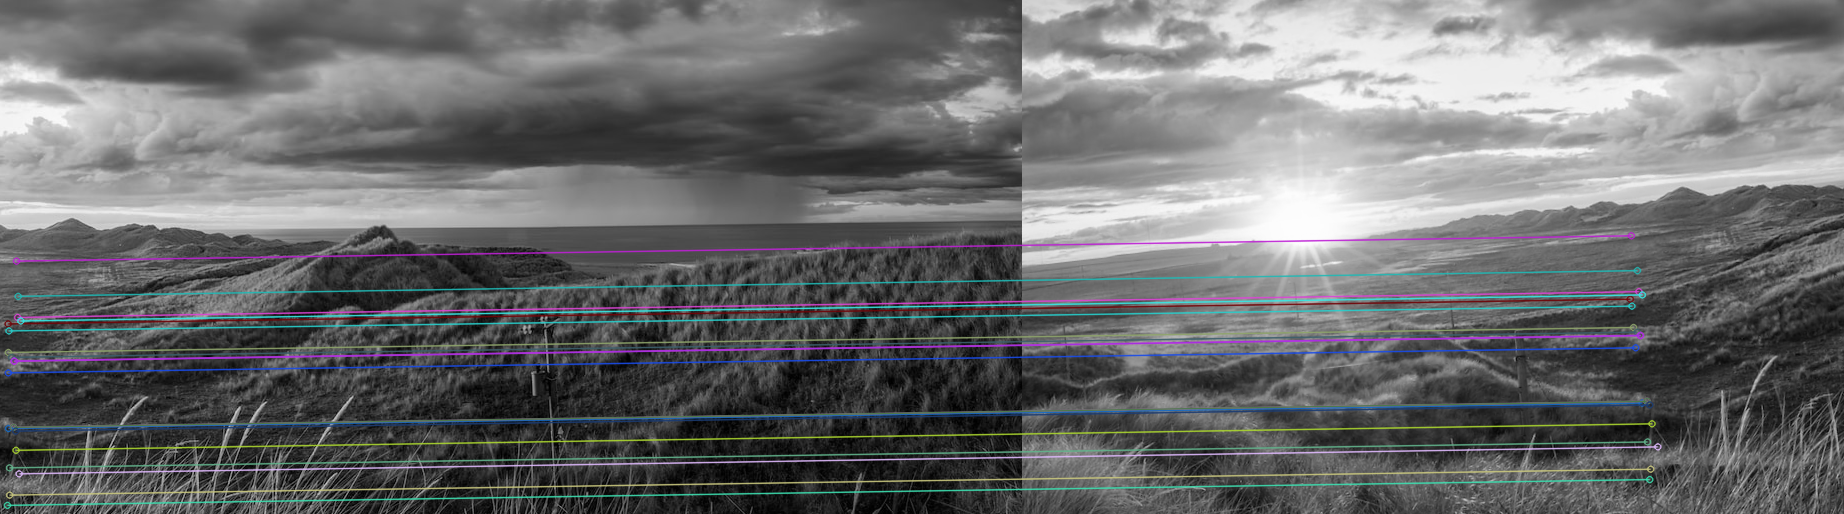

In [ ]:
cv2_imshow(flann_matches_2)

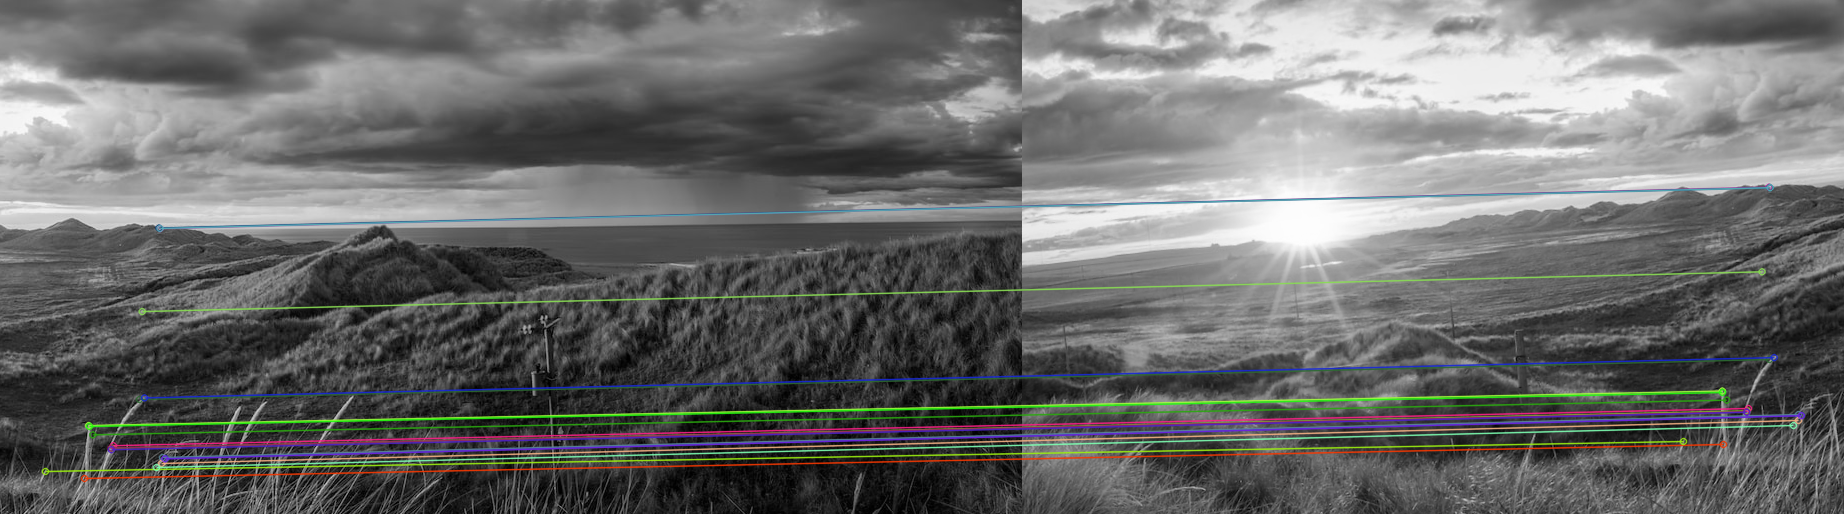

In [ ]:
cv2_imshow(ORB_matches_2)

In [ ]:
class Image_Stitching():
    def __init__(self) :
        self.ratio=0.8
        self.min_match=10
        self.sift=cv2.xfeatures2d.SIFT_create()
        self.smoothing_window_size=800

    def homography(self,img1,img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matches = matcher_lowe(des1, des2)
        
        good_points = []
        good_matches = []
        for m1, m2 in matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        cv2.imwrite('matching.jpg', img3)

        if len(good_points) > self.min_match:
            image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self,img1,img2):
        H = self.homography(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result

def panorama(img1, img2):
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    final=Image_Stitching().blending(img1, img2)
    cv2.imwrite('panorama_2.jpg', final)

In [ ]:
panorama("/content/Intersect.png", "/content/Intersect-1.png")

In [ ]:
pan = cv2.imread("/content/panorama_2.jpg")
pan = cv2.cvtColor(pan, cv2.COLOR_BGR2GRAY)

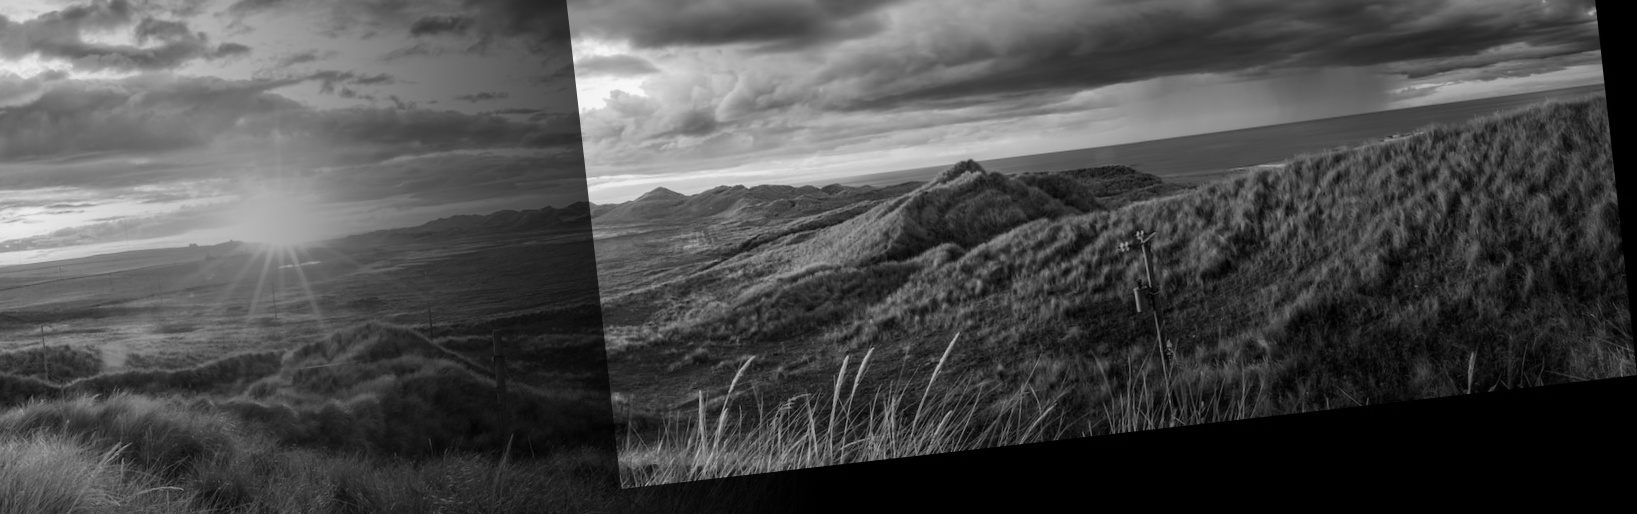

In [ ]:
cv2_imshow(pan)